# Neural Network

# Library Imports

In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset


# Load and Pre-processing Data Function


In [4]:
def process_and_load_data(data = pd.DataFrame, target = str):
    #The input should only be a Pandas DataFrame 
 
    #This creates split datasets for training, testing, and validation
    #Additionally it prepares the input data sets for model fitting and predicting
    X = data.drop(target, axis = 1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val =  scaler.transform(X_val)

    return X_train, X_test, X_val, y_train, y_test, y_val
 


# Model Accuracy & Fairness Assessment Functions

## Function to test the Model's Accuracy

In [28]:
def model_assessment(predictions, actuals):
    
    #Overall
    overall_accuracy = accuracy_score(actuals, predictions)
    overall_recall = recall_score(actuals, predictions)
    overall_precision = precision_score(actuals, predictions)



    results = pd.DataFrame({
        'Group': ['Overall'],
        'Accuracy': [overall_accuracy],
        'Recall': [overall_recall],
        'Precision': [overall_precision]
    })

    return results





In [35]:
def thresholds_assessment(raw_predictions, actuals, thresholds = list):
    accs =[]
    recalls = []
    precs = []
    for threshold in thresholds:
        new_preds = (raw_predictions >= threshold).astype(int)
        accs.append(accuracy_score(actuals, new_preds))
        recalls.append(recall_score(actuals, new_preds))
        precs.append(precision_score(actuals, new_preds))
    return {'Accuracy': accs, 'Recall': recalls, 'Precision': precs}

## Function to test the Model's Fairness between Males and Females

In [55]:
def fairness_metrics(input_df, predictions):

    binary_dataset = BinaryLabelDataset(df=input_df, 
                                    label_names=['Coronary heart disease'], 
                                    protected_attribute_names=['Gender'])

    # Create predictions dataset
    pred_df = input_df.drop('Coronary heart disease', axis = 1)
    pred_df['Coronary heart disease'] = predictions
    binary_predictions = BinaryLabelDataset(df=pred_df, 
                                            label_names=['Coronary heart disease'], 
                                            protected_attribute_names=['Gender'])

    # Compute metrics
    metric = ClassificationMetric(binary_dataset, binary_predictions, 
                                unprivileged_groups=[{'Gender': 0}], 
                                privileged_groups=[{'Gender': 1}]) 
    
    demographic_parity_difference = metric.statistical_parity_difference()
    equal_opportunity_difference = metric.equal_opportunity_difference()
    predictive_parity = metric.statistical_parity_difference()
    disparate_impact = metric.disparate_impact()


    #Output Metrics in a Pandas DataFrame
    fairness_table = pd.DataFrame({
        'Metric': ['Demographic Parity Difference', 'Equal Opportunity Difference',
                   'Predictive Parity', 'Disparate Impact'],
        'Value': [demographic_parity_difference, equal_opportunity_difference,
                  predictive_parity, disparate_impact]
    })

    return fairness_table


# Load Data Set

In [5]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


## Simple Baseline Neural Network

In [20]:
# Simple baseline model for 30 inputs
simple_nn = Sequential()
simple_nn.add(Dense(units=32, activation='relu', input_shape=(41,)))  # Input layer
simple_nn.add(Dropout(0.3))  # Dropout to prevent overfitting
simple_nn.add(Dense(units=16, activation='relu'))  # Hidden layer
simple_nn.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
simple_nn.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

# Summary of the model
simple_nn.summary()


/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,889 (7.38 KB)

 Trainable params: 1,889 (7.38 KB)

 Non-trainable params: 0 (0.00 B)

# Create Train/Test/Validation Sets

### One Hot Encoding and Binarization

In [6]:
# Male = 1
# Female = 0
# CHD Positive = 1
# CHD Negative = 1
df['Gender'] = df['Gender'].mask(df['Gender'] == 'Male', 1).mask(df['Gender'] == 'Female', 0)
df['Coronary heart disease'] = df['Coronary heart disease'].mask(df['Coronary heart disease'] == 'Yes', 1).mask(df['Coronary heart disease'] == 'No', 0)
categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [16]:
#Correct Data Type
df['Coronary heart disease'] = df['Coronary heart disease'].astype(int)
df['Gender'] = df['Gender'].astype(int)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = process_and_load_data(df, 'Coronary heart disease')

# Train Simple Neural Network

In [21]:
simple_nn.fit(X_train, y_train, epochs = 100)

Epoch 1/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.8745 - loss: 0.3077
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.9593 - loss: 0.1473
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.9578 - loss: 0.1459
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.9568 - loss: 0.1467
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.9584 - loss: 0.1411
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9599 - loss: 0.1336
Epoch 7/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9602 - loss: 0.1352
Epoch 8/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.9587 - loss: 0.1368
Epoch 9/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9585 - loss: 0.1368
Epoch 10/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9569 - loss: 0.1388
Epoch 11/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9580 - loss: 0.1376
Epoch 12/100
860/86

# Accuracy Assessment

### Test Set

In [22]:
loss_and_metrics = simple_nn.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.9581 - loss: 0.1533
[0.1526462286710739, 0.9567874073982239]
Loss =  0.1526462286710739
Accuracy =  0.9567874073982239


### Predictions Evaulation

In [29]:
raw_preds = simple_nn.predict(X_val)

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


### Default Threshold of 0.5

In [30]:
preds = (raw_preds >= 0.5).astype(int)

In [33]:
model_assessment(preds, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.959079,0.056657,0.322581


# Threshold Assesment

In [38]:
thresholds = np.arange(0.01,1, 0.05)

In [39]:
metrics = thresholds_assessment(raw_preds, y_val, thresholds)

/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

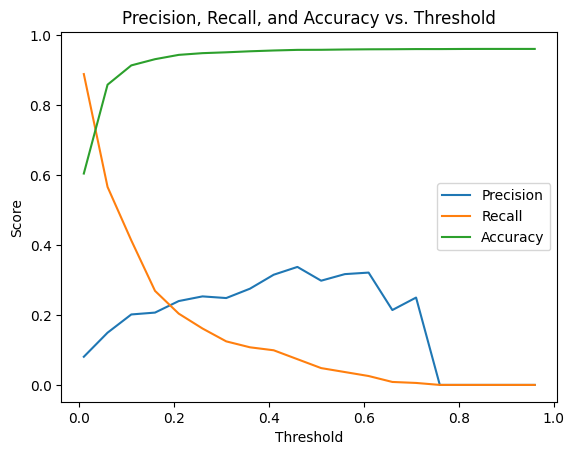

In [41]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()

### F1-Score Evaluation

In [43]:
f1_scores = []
for t in thresholds:
    preds = (raw_preds >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal threshold for F1-Score: {optimal_threshold}")

Optimal threshold for F1-Score: 0.11


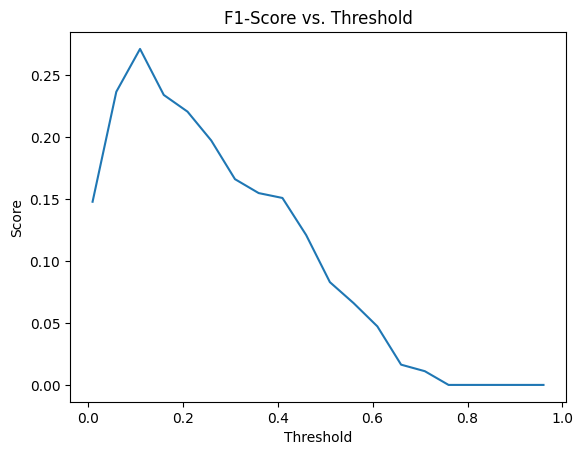

In [46]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score vs. Threshold')
plt.show()

In [47]:
preds = (raw_preds >= 0.11).astype(int)

In [48]:
model_assessment(preds, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.914339,0.413598,0.201657


# Fairness Assessment

In [56]:
X_train, X_test= train_test_split(df, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=42)
fairness_metrics(X_val, preds)

,Metric,Value
0,Demographic Parity Difference,-0.090429
1,Equal Opportunity Difference,-0.251929
2,Predictive Parity,-0.090429
3,Disparate Impact,0.279973
